In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd, numpy as np

train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
orig = pd.read_csv('/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv')
orig_2 = pd.read_csv('/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_10k.csv')
orig_3 = pd.read_csv('/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_2k.csv')
orig = pd.concat([orig, orig_2, orig_3])

print('Train Shape:', train.shape)
print('Test Shape:', test.shape)
print('Orig Shape:', orig.shape)

train.head(3)

Train Shape: (517754, 14)
Test Shape: (172585, 13)
Orig Shape: (112000, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30


In [3]:
TARGET = 'accident_risk'
BASE = [col for col in train.columns if col not in ['id', TARGET]]
CATS = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']
print(f'{len(BASE)} Base Features:{BASE}')

12 Base Features:['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents']


In [4]:
ORIG = []

for col in BASE:
    tmp = orig.groupby(col)[TARGET].mean()
    new_col_name = f"orig_{col}"
    tmp.name = new_col_name
    train = train.merge(tmp, on=col, how='left')
    test = test.merge(tmp, on=col, how='left')
    ORIG.append(new_col_name)

print(len(ORIG), 'Orig Features Created!!')

12 Orig Features Created!!


In [5]:
# https://www.kaggle.com/competitions/playground-series-s5e10/discussion/609994#3296622

from scipy.stats import norm

def f(X):
    return (
        0.3 * X["curvature"] +
        0.2 * (X["lighting"] == "night").astype(int) +
        0.1 * (X["weather"] != "clear").astype(int) +
        0.2 * (X["speed_limit"] >= 60).astype(int) +
        0.1 * (X["num_reported_accidents"] > 2).astype(int)
    )

def clip(f_to_clip):
    def clip_f(X):
        sigma = 0.05
        mu = f_to_clip(X)
        a = -mu / sigma
        b = (1 - mu) / sigma
        
        Phi_a = norm.cdf(a)
        Phi_b = norm.cdf(b)
        phi_a = norm.pdf(a)
        phi_b = norm.pdf(b)
        
        return mu * (Phi_b - Phi_a) + sigma * (phi_a - phi_b) + 1 - Phi_b
        
    return clip_f

META = []

clipped_f = clip(f)
for df in [train, test, orig]:
    df['Meta'] = clipped_f(df)

META.append('Meta')

In [6]:
FEATURES = BASE + ORIG + META
print(len(FEATURES), 'Features.')

25 Features.


In [7]:
X = train[FEATURES]
y = train[TARGET]

In [8]:
from sklearn.model_selection import KFold

N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [10]:
# RANDOM SEARCH
params = {'subsample': 0.8,
          'colsample_bytree': 0.8,
          'max_bin': 2000,
          'gamma': 0, 
          'grow_policy': 'depthwise',
          'max_depth': 7,
          'max_leaves': 0,
          'n_estimators': 100000, 
          'learning_rate': 0.01,
          'device': 'cuda',
          'early_stopping_rounds': 100,
          'enable_categorical': True
         }

In [11]:
import random

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

population = range(1, 100001)
SEED = random.sample(population, 20)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'---Fold {fold+1}/{N_SPLITS}---')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] 

    X_test = test[FEATURES].copy()

    X_train[CATS] = X_train[CATS].astype('category')    
    X_val[CATS] = X_val[CATS].astype('category')    
    X_test[CATS] = X_test[CATS].astype('category')    

    for seed in SEED:
    
        params['seed'] = seed
        model = XGBRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=2000, 
                 )

        oof_preds[val_idx] +=  model.predict(X_val) / len(SEED)
        test_preds += model.predict(X_test) / len(SEED)

    print(f"Fold {fold+1} RMSE: {mean_squared_error(y_val, oof_preds[val_idx], squared=False)}")

test_preds /= N_SPLITS

print(f"Overall OOF RMSE: {mean_squared_error(y, oof_preds, squared=False):.5f}")

---Fold 1/5---
[0]	validation_0-rmse:0.16471
[1461]	validation_0-rmse:0.05613
[0]	validation_0-rmse:0.16471
[1546]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16474
[1652]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1399]	validation_0-rmse:0.05613
[0]	validation_0-rmse:0.16471
[1525]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1591]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1695]	validation_0-rmse:0.05613
[0]	validation_0-rmse:0.16471
[1706]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1747]	validation_0-rmse:0.05613
[0]	validation_0-rmse:0.16471
[1588]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1543]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1756]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1694]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1675]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1538]	validation_0-rmse:0.05612
[0]	validation_0-rmse:0.16471
[1647]	val

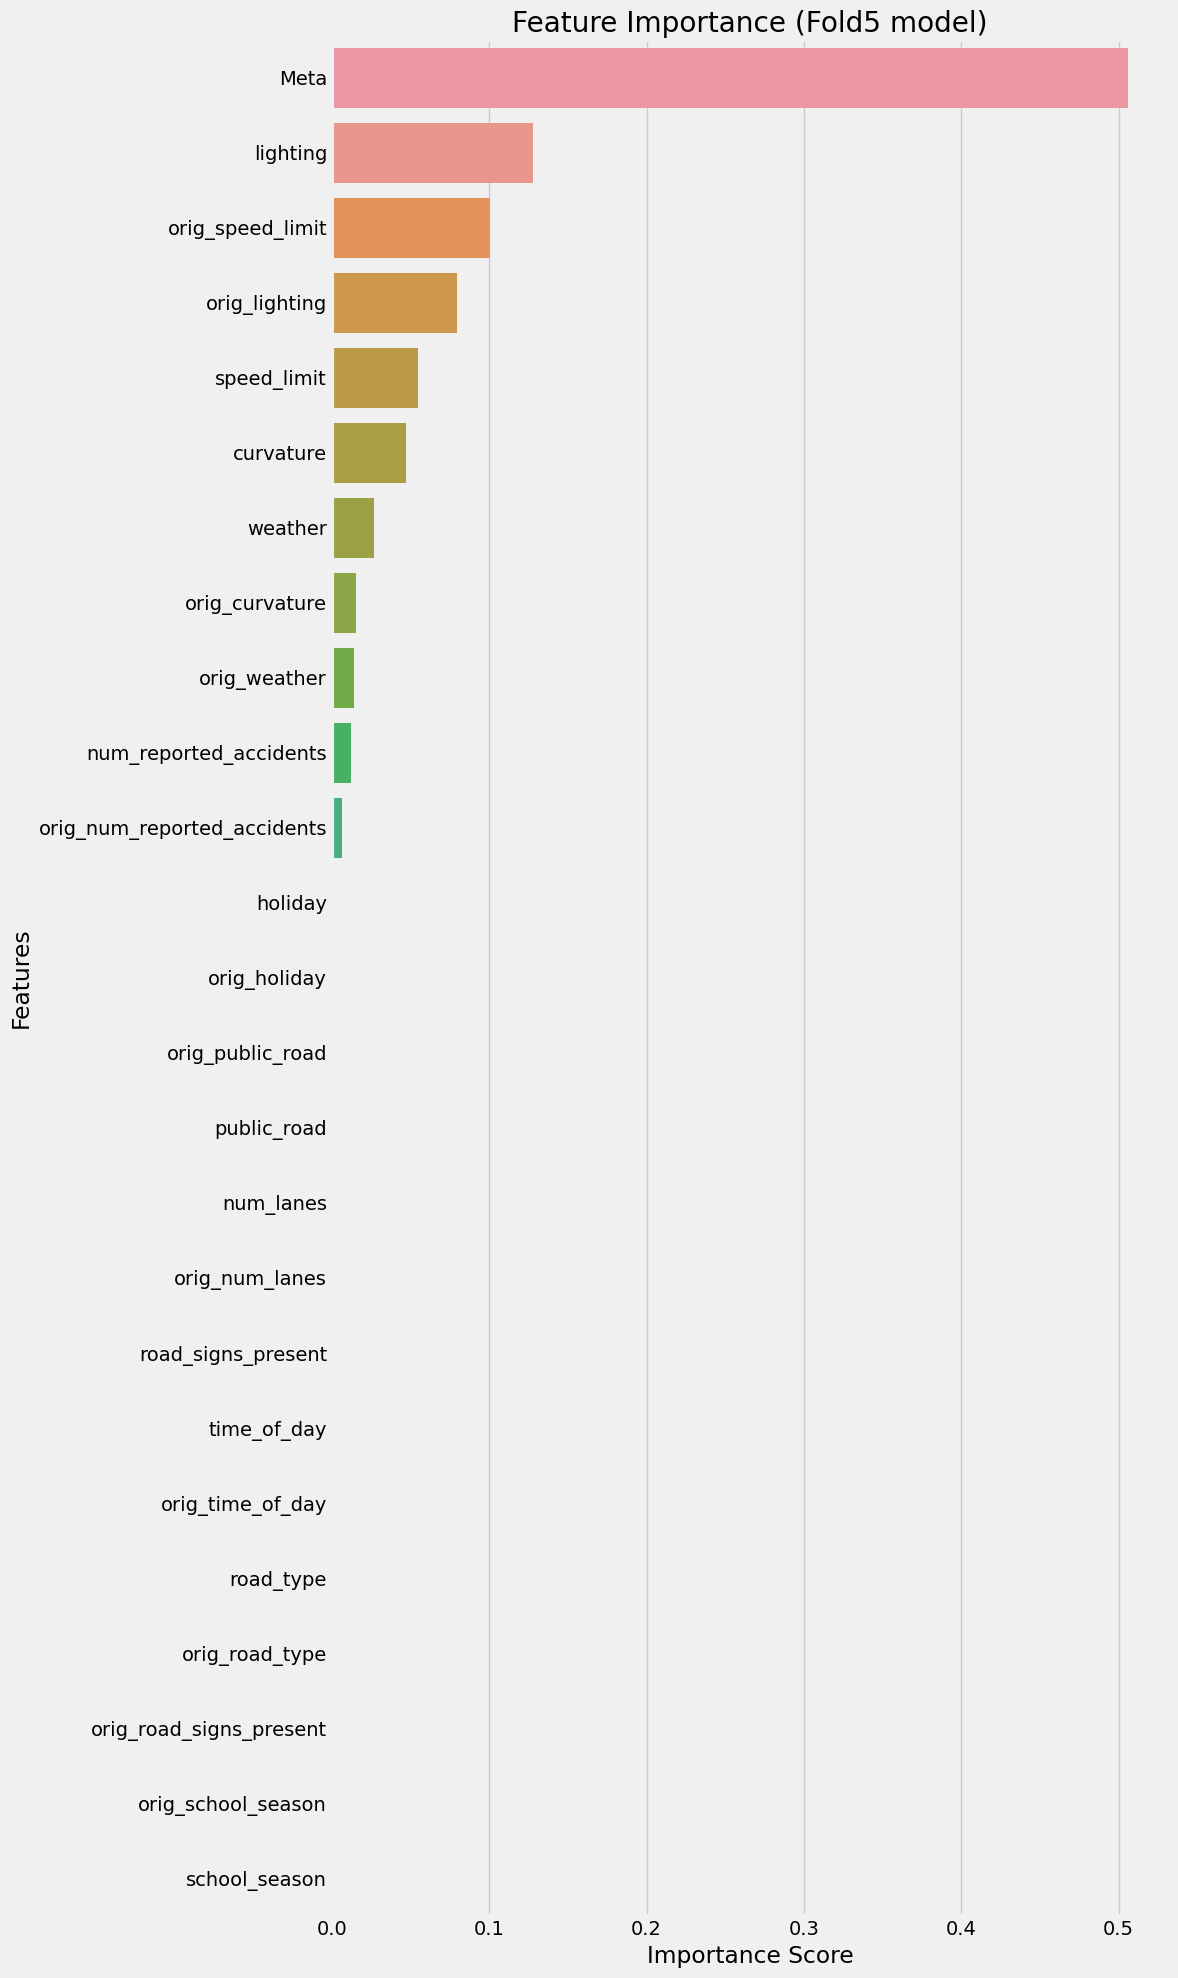

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': FEATURES, 
    'importance': feature_importances
})

importance_df = importance_df.sort_values('importance', ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 20))
sns.barplot(x='importance', 
            y='feature', 
            data=importance_df.head(50)) 
plt.title('Feature Importance (Fold5 model)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [13]:
pd.DataFrame({'id': train.id, TARGET: oof_preds}).to_csv('oof_xgb_plus_origcol.csv', index=False)
pd.DataFrame({'id': test.id, TARGET: test_preds}).to_csv('test_xgb_plus_origcol.csv', index=False)